# Estimating Resonance Using SParam1PModel data from reflection measurement of JPA

In [1]:
import matplotlib as mpl
import scipy.constants as cnst
from scipy.signal import savgol_filter, find_peaks
from IPython.core.display import display, HTML, Markdown
from functools import partial
import lmfit
import numpy as np


MIDFONTSIZE = 14

mpl.rcParams['font.size'] = MIDFONTSIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.labelsize'] = MIDFONTSIZE
mpl.rcParams['ytick.labelsize'] = MIDFONTSIZE
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt

from groundcontrol.analysis.plotting import plot2d, draw_text_box
from groundcontrol.measurement import read_measurement_csv, MeasurementModel, quantity, parameter, SParam1PModel
import groundcontrol.units as un
from groundcontrol.util import makeodd, find_nearest_idx


class DelayMeasurement(MeasurementModel):
    delays: np.ndarray = quantity(un.second, 'Group Delay')
    frequencies: np.ndarray = quantity(un.hertz, 'Frequency')
        
    @classmethod
    def from_sparam_phase(
            cls,
            s: SParam1PModel):
        fs = s.frequencies
        df = fs[1] - fs[0]
        # assuming degree phases
        delay = -(1/360)*np.diff(s.uphases)/df
        return cls(delay, fs[1:])
    
s2delay = DelayMeasurement.from_sparam_phase

# 0. Example Data

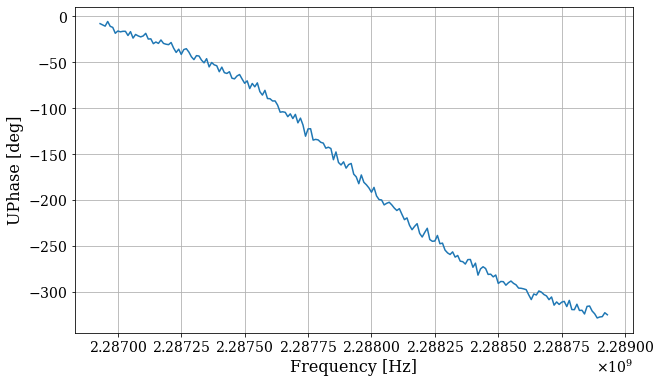

In [2]:
#spect = read_measurement_csv('../test/data/resonance/FJPA7G_CAL_NARROW_COARSE_NOISIER.csv')
spect = read_measurement_csv('data/jpa2.3_res.csv')

# Fake data with no peak
p1, p2 = spect.uphases[0], spect.uphases[100]
f1, f2 = spect.frequencies[0], spect.frequencies[100]
slope = (p2-p1)/(f2-f1)
trend = slope*spect.frequencies
trend = trend - trend[0]
noise = np.random.random(len(trend))*10
#spect.uphases = trend + noise

EXPECTEDBW = 1e6

pplot = partial(plot2d, names=('frequencies', 'uphases'))
dplot = partial(plot2d, names=('frequencies', 'delays'))
pplot(spect)

In [34]:
display(Markdown("**Metadata**"))
f = spect.frequencies
df = f[1] - f[0]
frange = f.min(), f.max()
span = frange[1] - frange[0]
npoints = len(f)
print(f"Range: {tuple(map(lambda d: d/1e9, frange))} GHz")
print(f"Span: {span/1e6:.3f} MHz")
print(f"Step: {df/1e6:.3f} MHz")

**Metadata**

Range: (5.292657342657343, 5.392657342657343) GHz
Span: 100.000 MHz
Step: 1.000 MHz


## 1. Resonance via Derivative
The resonance follows an arctangent relation with some baseline.  The straightforward method would be to take derivative of the signal and find the peak.  While this method is very susceptible to noise, it is very straightforward to implement and doesn't have a model assumption.

### 1.a Prefilter
In order to reduce the effect of noise, we need to do some filtering before taking the derivative.  We use Savitzky-Golay filter for this.  It's important to optimize parameters.

Smoothing window: 10 MHz
Window length: 11
Polynomial order: 3
Edge handling: mirror


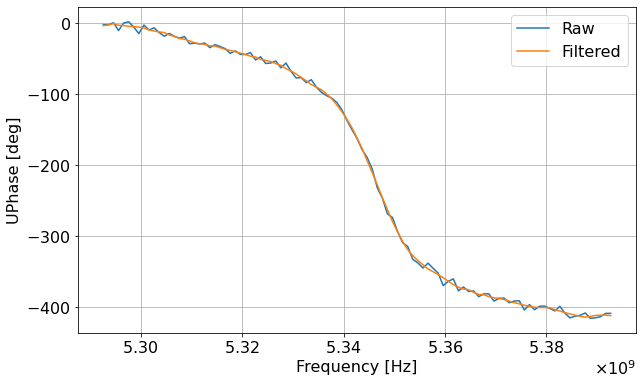

In [35]:
ph = spect.uphases

# Smoothing window
sw = EXPECTEDBW
print(f"Smoothing window: {sw/1e6:.0f} MHz")

# Window length makeodd(sw // df)
wl = makeodd(int(sw // df))
print(f"Window length: {wl:d}")

# Poly order
po = 3
print(f"Polynomial order: {po:d}")

# Mode
mode = 'mirror'
print(f"Edge handling: {mode:s}")

ph_sg = savgol_filter(ph, window_length=wl, polyorder=3, mode=mode)
spect_f = spect.evolve(uphases=ph_sg)
pplot(spect, label="Raw")
pplot(spect_f, label="Filtered")
plt.grid()
plt.legend()

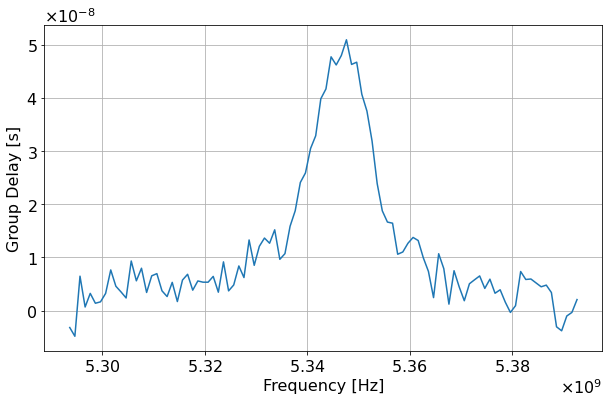

In [36]:
dm = s2delay(spect_f)
fig, ax = plt.subplots()
dplot(dm, ax=ax)
ax.grid(True)

In [37]:
def smoothify(
        spar: SParam1PModel,
        band: float,
        qname: str = 'uphases',
        porder: int = 3,
        drop_band_ratio: float = 0):
    """Applies a smoothing algorithm to the unwrapped phase data of the given SParam1PModel object.
    band:  The running frequency band at which the smoothing is applied.
    porder:  Polynomial order for the SG filter smoothing.
    drop_band_ratio:  If 0.1, 0.05 times the `band` is cut from each side of the spectrum from the end result.
    """
    qval = getattr(spar, qname)
    fs = spar.frequencies
    df = fs[1] - fs[0]
    wl = makeodd(int(band // df))
     
    qval = savgol_filter(qval, window_length=wl, polyorder=porder, mode='mirror')
    dropband = drop_band_ratio * band
    fs_max = fs.max() - dropband/2
    fs_min = fs.min() + dropband/2
    inds = np.where((fs >= fs_min)*(fs<=fs_max))[0]
    sparnew = spar.evolve(**{qname: qval})
    new = sparnew.cut(inds)
    return new

def estimate_resonance(
        spar, bw_expected: float, upsample: int = 20,
        return_aux: bool = False, smoothbandfactor=1):
    smband = bw_expected*smoothbandfactor
    smoothed_phase = smoothify(spar, smband, drop_band_ratio=0.5)
    delay = s2delay(smoothed_phase)
    smoothed_delay = smoothify(delay, smband, qname='delays', porder=3)
    delays = smoothed_delay.delays
    fs = smoothed_delay.frequencies
    fs_min, fs_max, n = fs.min(), fs.max(), len(fs)
    fsnew = np.linspace(fs_min, fs_max, upsample*n)
    interped = np.interp(fsnew, fs, delays)
    
    df = fsnew[1] - fsnew[0]
    width = bw_expected // df
    # Min height = halfmax
    halfmax = 1/(np.pi*bw_expected)
    peakinds, props = find_peaks(interped, width=width, height=halfmax)
    npeak = len(peakinds)
    print(f"PEAKS: {npeak:d}")
    if npeak == 0:
        fres = None
    elif npeak == 1:
        fres = fsnew[peakinds[0]]
    elif npeak <= 5:
        # If multiple peak found, return the one with the maximum height at half power.
        _indmax = props['width_heights'].argmax()
        fres = fsnew[peakinds[_indmax]]
    else:
        fres = None
    imax = np.argmax(interped)
    if not return_aux:
        return fres
    else:
        return fres, smoothed_phase, delay, smoothed_delay, fsnew, interped

### 1.c Postfilter

Smoothing window: 10 MHz
Window length: 11
Polynomial order: 3
Edge handling: mirror


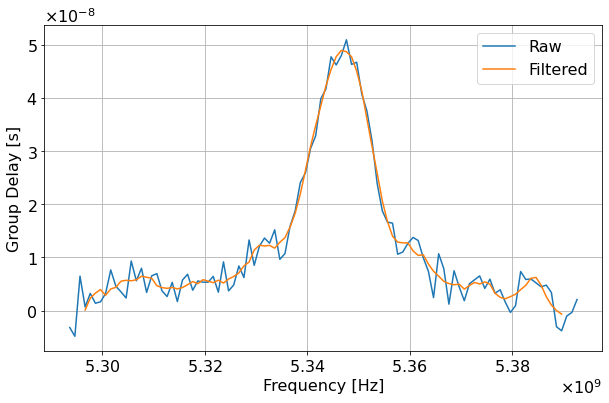

In [38]:
dm = s2delay(spect_f)
dly = dm.delays

# Smoothing window
sw = EXPECTEDBW
print(f"Smoothing window: {sw/1e6:.0f} MHz")

# Window length makeodd(sw // df)
wl = makeodd(int(sw // df))
print(f"Window length: {wl:d}")

# Poly order
po = 3
print(f"Polynomial order: {po:d}")

# Mode
mode = 'mirror'
print(f"Edge handling: {mode:s}")

dm_f = smoothify(dm, band=sw, qname='delays', porder=3, drop_band_ratio=0.5)
dplot(dm, label="Raw")
dplot(dm_f, label="Filtered")
plt.grid()
plt.legend()

### 1.d Estimate Resonance
Resonance is estimated using the final filtered waveform.  The simplest way is to find the maximum point, but then we need to define the 'not peak' case as well.  `find_peaks` from `scipy.signal` conveniently does that for us, so we use that.

PEAKS: 1


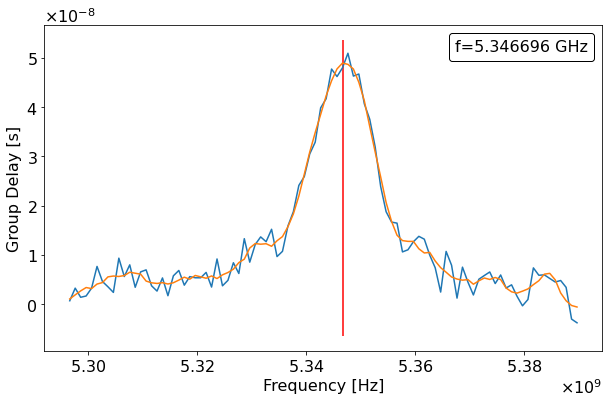

In [39]:
fres, phsg, dly, dlysg, fsnew, interped = estimate_resonance(spect, 10e6, return_aux=True, upsample=20)
fig, ax = plt.subplots()
dplot(dly, ax=ax)
dplot(dlysg, ax=ax)
ylim = ax.get_ylim()
ax.vlines(fres, ylim[0], ylim[1], 'r')

if fres is not None:
    txt = f"f={fres/1e9:.6f} GHz"
else:
    txt = "No resonance."
draw_text_box(ax, txt, 'upper right')


# 2. Resonance via Fit
Model function for the phase response of a resonator overcoupled to the it's transmission lines:
$$
\phi = \phi_0 - a f + 2 \arctan{\left(\frac{f_0}{\Gamma}(1-f/f_0)\right)} \\
a = \left(\frac{L}{v_p}\right) 2\pi \\
\Gamma = \mathrm{BW}/2 = f/2Q
$$

- The 1st term is just the reference phase.
- The 2nd term comes from the assumption of phase change along a TEM line.  The transmission chain and the reception has a lot of cables and components, single values for $L$ and $v_p$ are just an approximation.
- The 3rd term is from the assumption that the passive resonator can be approximated with an effective RLC circuit around it's resonance.
- This ignores the effect of coupling, the estimated biases and frequencies will have some bias.

Here are some values for reference for the phase velocity ($v_p$) and expected electrical length (L):

$$
v_p = 0.695c , \, \mathrm{(Solid\ PTFE)}\\
L = 12 \pm 5 \mathrm{m}\\
a = 0.3618\, \mathrm{rad}/\mathrm{MHz}
$$


## 2.1 Making the model

In [5]:
v_ptfe_nom = 0.695*cnst.speed_of_light
v_p_nom = v_ptfe_nom
L_min = 12 - 5
L_max = 12 + 5
a_min = (L_min/v_p_nom)*2*np.pi
a_max = (L_max/v_p_nom)*2*np.pi
a_nom = np.mean((a_min, a_max))
print(f"a (min, nom, max) ({a_min, a_nom, a_max}) rad/Hz") 

a (min, nom, max) ((2.1109230436923417e-07, 3.6187252177583e-07, 5.126527391824259e-07)) rad/Hz


In [6]:
@lmfit.Model
def phase_model_deg_simple(f, fr, bandwidth, phi0=0, length=12, v_p=v_ptfe_nom):
    a = 2*np.pi*(length/v_p)
    gamma = bandwidth/2
    const = phi0
    lin = -a*f
    res = 2*np.arctan((fr/gamma)*(1-f/fr))
    phi = const + (lin + res)*(360/(2*np.pi))
    return phi

phase_model_deg_simple.set_param_hint('v_p', vary=False)

model = phase_model_deg_simple

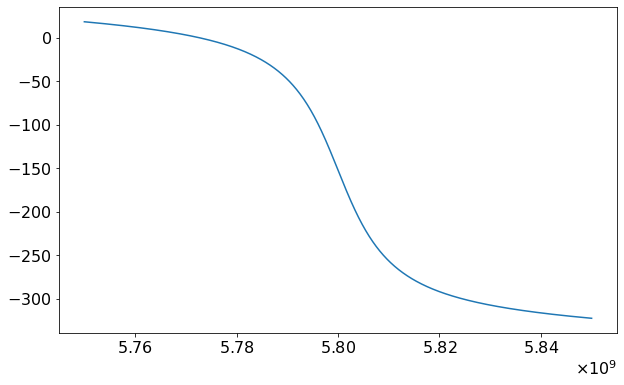

In [42]:
# Plot the model
fdomain = np.linspace(5.75e9, 5.85e9, 1000)
phases = model.eval(f=fdomain, fr=5.8e9, bandwidth=16e6, length=0.1, phi0=850)

plt.plot(fdomain, phases)

In [43]:
params = model.make_params(fr=np.median(spect.frequencies), bandwidth=16e6, length=12, phi0=4510)
print(params)

fitresult = model.fit(data=spect.uphases, f=spect.frequencies, params=params)
plt.plot(spect.frequencies, fitresult.data, 'ok')
plt.plot(spect.frequencies, fitresult.best_fit, '-r')
print(fitresult.fit_report())

Parameters([('fr', <Parameter 'fr', 5342657342.657343, bounds=[-inf:inf]>), ('bandwidth', <Parameter 'bandwidth', 16000000.0, bounds=[-inf:inf]>), ('v_p', <Parameter 'v_p', value=208355758.30999997 (fixed), bounds=[-inf:inf]>), ('length', <Parameter 'length', 12, bounds=[-inf:inf]>), ('phi0', <Parameter 'phi0', 4510, bounds=[-inf:inf]>)])
[[Model]]
    Model(phase_model_deg_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 101
    # variables        = 4
    chi-square         = 2262.57952
    reduced chi-square = 23.3255621
    Akaike info crit   = 322.023171
    Bayesian info crit = 332.483653
[[Variables]]
    fr:         5.3457e+09 +/- 106004.068 (0.00%) (init = 5.342657e+09)
    bandwidth:  13002406.6 +/- 239432.780 (1.84%) (init = 1.6e+07)
    v_p:        2.083558e+08 (fixed)
    length:     0.50475616 +/- 0.01221151 (2.42%) (init = 12)
    phi0:       4447.26433 +/- 112.711739 (2.53%) (init = 4510)
[[Correlations]] (u

## 2.2 Using the implemented model from groundcontrol

In [3]:
from groundcontrol.estimation import phasemodel

In [4]:
params = phasemodel.guess(f=spect.frequencies, data=spect.uphases)
fit = phasemodel.fit(f=spect.frequencies, data=spect.uphases, params=params)

In [5]:
print(fit.fit_report())
fit.plot()

[[Model]]
    Model(resonator_phase_response_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 201
    # variables        = 4
    chi-square         = 2268.57430
    reduced chi-square = 11.5156056
    Akaike info crit   = 495.143991
    Bayesian info crit = 508.357211
[[Variables]]
    fr:    2.2879e+09 +/- 3802.44344 (0.00%) (init = 2.28793e+09)
    bw:    975280.153 +/- 12027.0164 (1.23%) (init = 200000)
    phi0:  71963.8853 +/- 2339.55846 (3.25%) (init = 39325.83)
    elen:  18.2465526 +/- 0.59182315 (3.24%) (init = 10)
    vp:    2.083558e+08 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(phi0, elen) =  1.000
    C(bw, elen)   =  0.915
    C(bw, phi0)   =  0.915


(<Figure size 720x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

In [42]:
asrat = 3/2  # w/h
width = 2.7

FS = MIDFONTSIZE-2

mpl.rcParams['font.size'] = FS
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.labelsize'] = FS
mpl.rcParams['ytick.labelsize'] = FS
plt.subplots(figsize=(width, width/asrat))
plt.plot(spect.frequencies/1e9, (360 + spect.uphases)/180, 'ok', label='Data', markerfacecolor='white', markersize=4)
plt.plot(spect.frequencies/1e9, (360 + fit.best_fit)/180, '-r', label='Fit', linewidth=2)
plt.ylabel('$ \\theta / \pi $')
plt.xlabel('f (GHz)')
plt.legend(fontsize=FS, handlelength=0.5)
plt.xticks(rotation=0)
plt.locator_params(axis='x', nbins=3)
name = 'phasefit'

plt.savefig(f"/home/ckutlu/Work/documents/article-jpa/img/{name}.pdf")
plt.savefig(f"/home/ckutlu/Work/documents/article-jpa/img/{name}.png", dpi=300)
plt.savefig(f"/home/ckutlu/Work/documents/article-jpa/img/{name}.svg")